In [1]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-hyeok: tlsehdgur0@kaist.ac.kr
'''

import time
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras


In [2]:
class VariationalAutoEncoder:

    network_architecture = [] # network_architecture : 인공신경망의 구조를 저장
    all_weights = {}
    transfer_fct = 0

    x = [] # x : VAE의 Input
    x_reconstr_mean = [] # x_reconstr_mean : VAE의 Output
    z = [] # z : VAE의 latent variable
    z_mean = [] # z_mean : VAE의 latent variable의 mean
    z_log_sigma_sq = [] # z_log_sigma_sq : VAE의 latent variable의 log sigma sq

    cost = 0
    optimizer = 0
    
    learning_rate = 0
    network_weights = {}
    
    def __init__(self,network_architecture,transfer_fct=tf.nn.sigmoid):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct # self.transfer_fct : activation function을 저장, 기본값은 sigmoid function으롤 설정


    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, n_hidden_gener_1, n_hidden_gener_2, n_input, n_z):

        self.all_weights['weights_recog'] = { 'h1' : tf.Variable(self.xavier_init(n_input,n_hidden_recog_1),dtype=tf.double, trainable=True), \
                                         'h2' : tf.Variable(self.xavier_init(n_hidden_recog_1,n_hidden_recog_2),dtype=tf.double, trainable=True), \
                                         'out_mean': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z),dtype=tf.double, trainable=True), \
                                         'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_recog_2, n_z),dtype=tf.double, trainable=True)}

        self.all_weights['biases_recog'] = { 'b1' : tf.Variable(tf.zeros([n_hidden_recog_1],dtype=tf.double), trainable=True), \
                                        'b2' : tf.Variable(tf.zeros([n_hidden_recog_2],dtype=tf.double), trainable=True), \
                                        'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.double), trainable=True), \
                                        'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.double), trainable=True)}        
        
        self.all_weights['weights_gener'] = {'h1': tf.Variable(self.xavier_init(n_z, n_hidden_gener_1),dtype=tf.double, trainable=True), \
                                        'h2': tf.Variable(self.xavier_init(n_hidden_gener_1, n_hidden_gener_2),dtype=tf.double, trainable=True), \
                                        'out_mean': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input),dtype=tf.double, trainable=True), \
                                        'out_log_sigma': tf.Variable(self.xavier_init(n_hidden_gener_2, n_input),dtype=tf.double, trainable=True)}

        self.all_weights['biases_gener'] = {'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.double), trainable=True), \
                                       'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.double), trainable=True), \
                                       'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.double), trainable=True), \
                                       'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.double), trainable=True)}
        return self.all_weights

    def _recognition_network(self,weights,biases,x=None): 
        # VAE의 recognition network의 역할을 수행하는 method
        # Input : (recognition network의) weights, biases
        # Output: (z_mean, z_log_sigma_sq)

        layer_1 = self.transfer_fct(tf.add(tf.matmul(x, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*X)
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        
        z_mean = tf.add(tf.matmul(layer_2,weights['out_mean']),biases['out_mean']) # z_mean = b_{out_mean} + W_{out mean}*L2
        z_log_sigma_sq = tf.add(tf.matmul(layer_2,weights['out_log_sigma']),biases['out_log_sigma'])
        # z_log_sigma_sq = b_{log_sigma_sq} + W_{log_sigma_sq}*L2
        return (z_mean,z_log_sigma_sq)

    def _generator_network(self,weights,biases,z=None):
        # VAE의 generator network의 역할을 수행하는 method
        # Input : (generator network의) weights, biases
        # Output : x_reconstr_mean
        layer_1 = self.transfer_fct(tf.add(tf.matmul(z, weights['h1']), biases['b1'])) # L1 = g(b1 + W1*Z)
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])) # L2 = g(b2 + W2*L1)
        x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), biases['out_mean']))
        # x_reconstr_mean = b_{out_mean}+W_{out_mean}*L2
        return x_reconstr_mean

    def _reparameterization(self, z_mean, z_log_sigma_sq):
        # Z mean과 Z sigma를 이용해 Z를 reparameterize하는 method
        # Input : z_mean, z_log_sigma_sq
        # Output : z
        
        n_z = self.network_architecture["n_z"]
        n_batch = len(z_log_sigma_sq)
        eps = tf.random.normal((n_batch,n_z),0,1,dtype=tf.double)
                
        z = tf.add(z_mean,tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)),eps))
        
        return z
    
    def get_weights(self):
        # Training될 weight를 모두 반환하는 method

        weights = []
        weights.append(self.all_weights["weights_recog"]['h1'])
        weights.append(self.all_weights["biases_recog"]['b1'])
        weights.append(self.all_weights["weights_recog"]['h2'])
        weights.append(self.all_weights["biases_recog"]['b2'])
        weights.append(self.all_weights["weights_recog"]['out_mean'])
        weights.append(self.all_weights["biases_recog"]['out_mean'])        
        weights.append(self.all_weights["weights_recog"]['out_log_sigma'])
        weights.append(self.all_weights["biases_recog"]['out_log_sigma'])
        weights.append(self.all_weights["weights_gener"]['h1'])
        weights.append(self.all_weights["biases_gener"]['b1'])
        weights.append(self.all_weights["weights_gener"]['h2'])
        weights.append(self.all_weights["biases_gener"]['b2'])
        weights.append(self.all_weights["weights_gener"]['out_mean'])
        weights.append(self.all_weights["biases_gener"]['out_mean'])     
        
        return weights
        
    def model(self, x):
        # VAE의 encoder/decoder network를 거쳐 cost를 반환하는 메소드
        # Input : x (Input)
        # Output : Cost
        self.x = x
        
        #recognition network
        weights, biases = self.all_weights["weights_recog"], self.all_weights["biases_recog"] 
        self.z_mean, self.z_log_sigma_sq = self._recognition_network(weights,biases,x)
        
        #reparameterization
        self.z = self._reparameterization(self.z_mean, self.z_log_sigma_sq)

        #generator network
        weights, biases = self.all_weights["weights_gener"], self.all_weights["biases_gener"]       
        self.x_reconstr_mean = self._generator_network(weights,biases, self.z)
        

        reconstr_loss = -tf.reduce_sum(x*tf.math.log(1e-10+self.x_reconstr_mean)+(1-x)*tf.math.log(1e-10+1-self.x_reconstr_mean),1)
        latent_loss = -0.5*tf.reduce_sum(1+self.z_log_sigma_sq-tf.square(self.z_mean)-tf.exp(self.z_log_sigma_sq),1)

        self.cost = tf.reduce_mean(reconstr_loss+latent_loss)
        return self.cost
    
        
    def _create_loss_optimizer(self,learning_rate):
        # VAE의 total cost를 계산하고, 이를 minimize하는 optimizer 설정하는 메소드
        # Input : learning_rate
        # Output : None
        self.learning_rate = learning_rate
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    def train_step(self, inputs):
        # VAE weight들의 gradient를 계산하고 optimize하는 method
        # Input : inputs
        # Output : current_loss
        
        with tf.GradientTape() as tape:
            current_loss = self.model(tf.Variable(inputs))
            weights = self.get_weights() 
            
        grads = tape.gradient( current_loss , weights )
        
        self.optimizer.apply_gradients( zip( grads , weights ) )

        return current_loss

    def transform(self,x):
        # VAE의 encoder network를 통하여 latent variable z의 mean을 return하는 메소드
        # Input : x
        # Output : z_mean
        z_mean, z_log_sigma_sq = self._recognition_network(self.all_weights['weights_recog'],self.all_weights["biases_recog"],x)
        return z_mean

    def generate(self,z_mu=None):
        # VAE의 decoder network를 통하여 reconstruct된 mean을 return하는 메소드
        # Input : z_mu
        # Output : reconstr_mean        
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
            
        reconstr_mean = self._generator_network(self.all_weights["weights_gener"],self.all_weights["biases_gener"],z_mu)
        return reconstr_mean
    
    def reconstruct(self,x):
        # VAE를 통하여 X를 reconstruct한 후, 이의 mean을 return하는 메소드
        # Input : x
        # Output : (VAE를 통한) x_reconstr_mean
        
        return self.generate(self.transform(x))

        
    def xavier_init(self,fan_in, fan_out, constant=1): 
        # Xavier initialization method
        # Input : fan_in(들어오는 layer의 크기), fan_out(나가는 layer의 크기)
        # Output : 각 원소가 random uniform value인 (fan_in, fan_out) 형태의 tensor 
        low = -constant * np.sqrt(6.0 / (fan_in + fan_out))
        high = constant * np.sqrt(6.0 / (fan_in + fan_out))

        return tf.random.uniform((fan_in, fan_out), minval=low, maxval=high, dtype=tf.double)

    def train(self,trainX,batch_size=100,training_epochs=500,learning_rate=0.0005):
        # VAE를 생성하고, trainX를 training하는 메소드
        # Input : trainX, batch_size, training_epochs, learning_rate
        # Output : None
        
        total_costs = np.zeros(training_epochs)
        
        self.all_weights = self._initialize_weights(**self.network_architecture) #weight 초기화
        self._create_loss_optimizer(learning_rate) # VAE의 loss function과 optimizer 생성
        
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.gpu.set_per_process_memory_fraction(0.333)
        
        startTime = time.time()
        for epoch in range(training_epochs): # training_epochs만큼 반복 실행
            avg_cost = 0. # training set의 average cost 
            total_batch = int(len(trainX)/batch_size) # total batch : 전체 batch의 갯수

            for i in range(total_batch): # total_batch만큼 반복 실행
                batch = [] 
                for j in range(batch_size):
                    batch.append(trainX[i*batch_size+j]) # training X를 여러개로 batch로 나누는 과정

                cost = self.train_step(batch)
                avg_cost += cost / n_samples*batch_size
            
            total_costs[epoch] = avg_cost
            
            print("Epoch : ",'%04d'%(epoch+1)," Cost = ","{:.9f}".format(avg_cost))
            print("Elapsed Time : " + str((time.time() - startTime))) # 각 epcoh의 실행 소요 시간
       
        # epcch에 따른 cost 그래프 출력 과정
        plt.plot(total_costs)
        plt.xlabel('epoch')
        plt.ylabel('cost')
        plt.show()
        return


    def plotReconstruct(self,testData,strFileName):
    # testData를 VAE를 통해 reconstruct한 후, Input test image와 reconstructedf output image를 plot하는 메소드  
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        x_reconstruct = self.reconstruct(testData) # x_reconstruct : testData를 이용하여 X를 reconstruct한 데이터
        plt.figure(figsize=(8, 12))
        for i in range(5): # testData의 처음 5개를 plot

            # Original Input image plot
            plt.subplot(5, 2, 2 * i + 1)
            plt.imshow(testData[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Test Input")
            plt.colorbar()

            # Reconstructed Output image plot
            plt.subplot(5, 2, 2 * i + 2)
            temp = tf.reshape(x_reconstruct[i],[28,28])
            plt.imshow(temp, vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환

#             plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray") # 784 차원의 벡터를 28*28 픽셀의 이미지로 변환
            plt.title("Reconstruction")
            plt.title("Reconstruction")
            plt.colorbar()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotScatter2D(self,testDataFeature,testDataClass,strFileName):
        # test data와 label을 2-D latent Space위에 Scatter plot으로 표현하는 메소드
        
        idxLastSlash = strFileName.rfind("/")
        if os.path.exists(strFileName[0:idxLastSlash]) == False:
            os.makedirs(strFileName[0:idxLastSlash])
        z_mu = self.transform(testDataFeature)

#         z_mu = self._recongnition_network()
        plt.figure(figsize=(8, 6))
        plt.scatter(z_mu[:,0],z_mu[:,1],c=testDataClass)
        plt.colorbar()
        plt.grid()

        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()

    def plotManifold2D(self,intNumX1,intNumX2,maxX1,minX1,maxX2,minX2,batch_size,strFileName):
        # walking in latent space를 표현하는 메소드
        x1s = np.linspace(minX1, maxX1, intNumX1)
        x2s = np.linspace(minX2, maxX2, intNumX2)
        canvas = np.empty((28*intNumX2,28*intNumX1))
        for i, yi in enumerate(x1s):
            for j, xi in enumerate(x2s):
                z_mu = np.array([[xi,yi]]*batch_size)
                x_mean = self.generate(z_mu)
                canvas[(intNumX1-i-1)*28:(intNumX1-i)*28,j*28:(j+1)*28] = tf.reshape(x_mean[0],[28,28])
        plt.figure(figsize=(8, 6))
        xi, yi = np.meshgrid(x1s,x2s)
        plt.imshow(canvas,origin='upper',cmap='gray')
        plt.tight_layout()
        plt.show()
        plt.savefig(strFileName, bbox_inches='tight')
        plt.close()          

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(60000, 784).astype('double')
x_test = x_test.reshape(10000, 784)

n_samples =len(x_train)


Epoch :  0001  Cost =  207.925412559
Elapsed Time : 24.520029544830322
Epoch :  0002  Cost =  186.034399302
Elapsed Time : 49.51489853858948
Epoch :  0003  Cost =  176.783845941
Elapsed Time : 74.23089122772217
Epoch :  0004  Cost =  162.486469092
Elapsed Time : 98.61977219581604
Epoch :  0005  Cost =  157.036492032
Elapsed Time : 122.8825421333313
Epoch :  0006  Cost =  153.728306596
Elapsed Time : 147.00263357162476
Epoch :  0007  Cost =  151.382017041
Elapsed Time : 171.64132022857666
Epoch :  0008  Cost =  149.490476831
Elapsed Time : 195.01081371307373
Epoch :  0009  Cost =  147.869890974
Elapsed Time : 218.70444107055664
Epoch :  0010  Cost =  146.608358394
Elapsed Time : 242.54245328903198
Epoch :  0011  Cost =  145.455299693
Elapsed Time : 267.7996039390564
Epoch :  0012  Cost =  144.496143433
Elapsed Time : 291.44691348075867
Epoch :  0013  Cost =  143.694753577
Elapsed Time : 313.238627910614
Epoch :  0014  Cost =  142.936454730
Elapsed Time : 336.86098051071167
Epoch :  0015

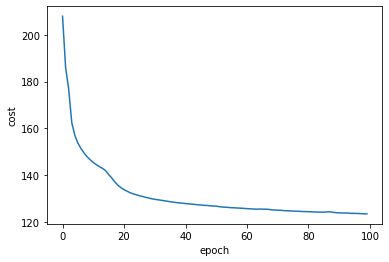

In [6]:
# z dimension이 10인 VAE의 구조를 저장
# 784 500 500 10 500 500 784
network_architecture = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=10)

vae = VariationalAutoEncoder(network_architecture) # z dimension이 10인 VAE instance 생성  
vae.train(x_train,batch_size=100,training_epochs=100,learning_rate=0.001) # VAE training


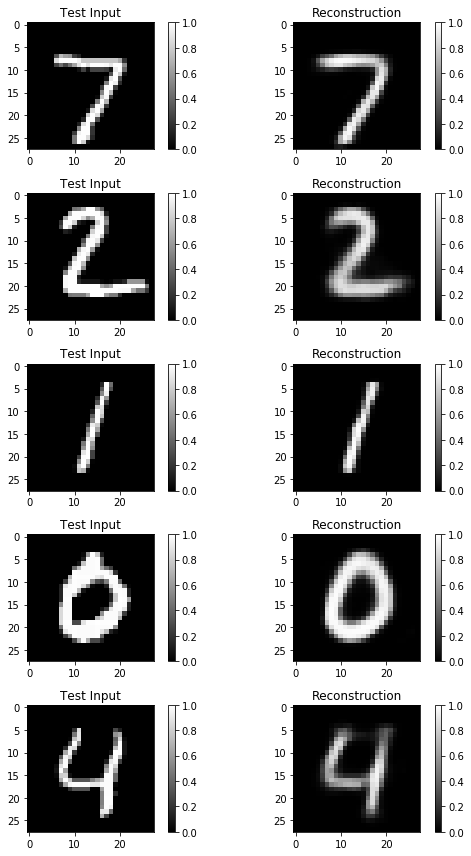

In [169]:
vae.plotReconstruct(x_test,'./log/VAE-Reconstruct.png') # testX를 이용하여 reconstruct한 후 이를 plot


Epoch :  0001  Cost =  232.971438272
Elapsed Time : 41.40804314613342
Epoch :  0002  Cost =  206.658768585
Elapsed Time : 80.1145851612091
Epoch :  0003  Cost =  206.592855546
Elapsed Time : 117.49387192726135
Epoch :  0004  Cost =  206.577834918
Elapsed Time : 154.9212281703949
Epoch :  0005  Cost =  206.565029767
Elapsed Time : 192.78716015815735
Epoch :  0006  Cost =  206.549771007
Elapsed Time : 230.17236304283142
Epoch :  0007  Cost =  206.252794755
Elapsed Time : 267.72849893569946
Epoch :  0008  Cost =  196.158095720
Elapsed Time : 305.60060119628906
Epoch :  0009  Cost =  190.921750520
Elapsed Time : 343.1864619255066
Epoch :  0010  Cost =  188.785229059
Elapsed Time : 381.3558850288391
Epoch :  0011  Cost =  187.468736257
Elapsed Time : 418.6360251903534
Epoch :  0012  Cost =  186.107733279
Elapsed Time : 456.10092401504517
Epoch :  0013  Cost =  185.032318757
Elapsed Time : 493.50578689575195
Epoch :  0014  Cost =  184.136182146
Elapsed Time : 531.226380109787
Epoch :  0015  

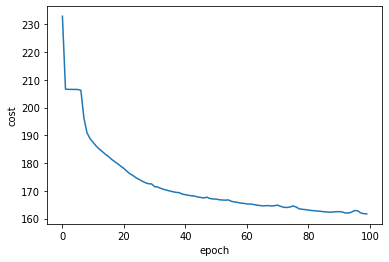

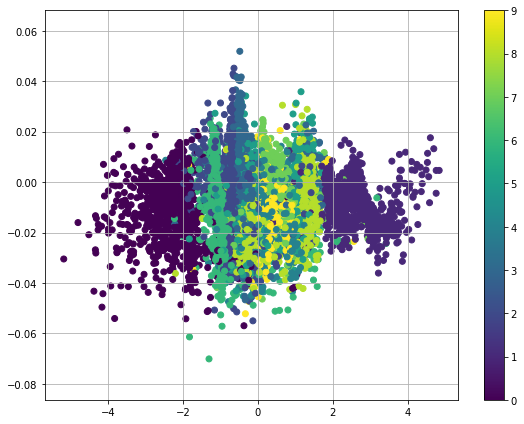

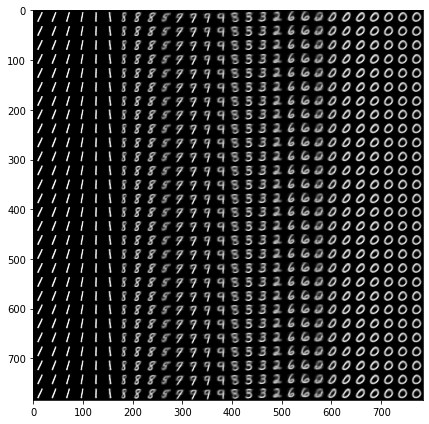

In [170]:
# z dimentsion이 2인 VAE의 구조를 저장
# 784 500 500 2 500 500 784
network_architecture2D = dict(n_hidden_recog_1=500,\
                            n_hidden_recog_2=500,\
                            n_hidden_gener_1=500,\
                            n_hidden_gener_2=500,\
                            n_input=784,\
                            n_z=2)



vae2D = VariationalAutoEncoder(network_architecture2D)
vae2D.train(x_train,batch_size=1000,training_epochs=100,learning_rate=0.001)
vae2D.plotScatter2D(x_test,y_test,'./log/VAE-2D-Scatter.png')
vae2D.plotManifold2D(28,28,-3,3,-3,3,1000,'./log/VAE-2D-Manifold.png')
